In [2]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d vuppalaadithyasairam/bone-fracture-detection-using-xrays

 97% 167M/172M [00:01<00:00, 138MB/s]
100% 172M/172M [00:01<00:00, 116MB/s]


In [4]:
!unzip -q bone-fracture-detection-using-xrays.zip

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [8]:
train_dir = 'archive (6)/train'
validation_dir = 'archive (6)/val'

In [9]:
BATCH_SIZE = 32
IMG_SIZE = (360, 360)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


Found 8863 files belonging to 2 classes.
Found 600 files belonging to 2 classes.


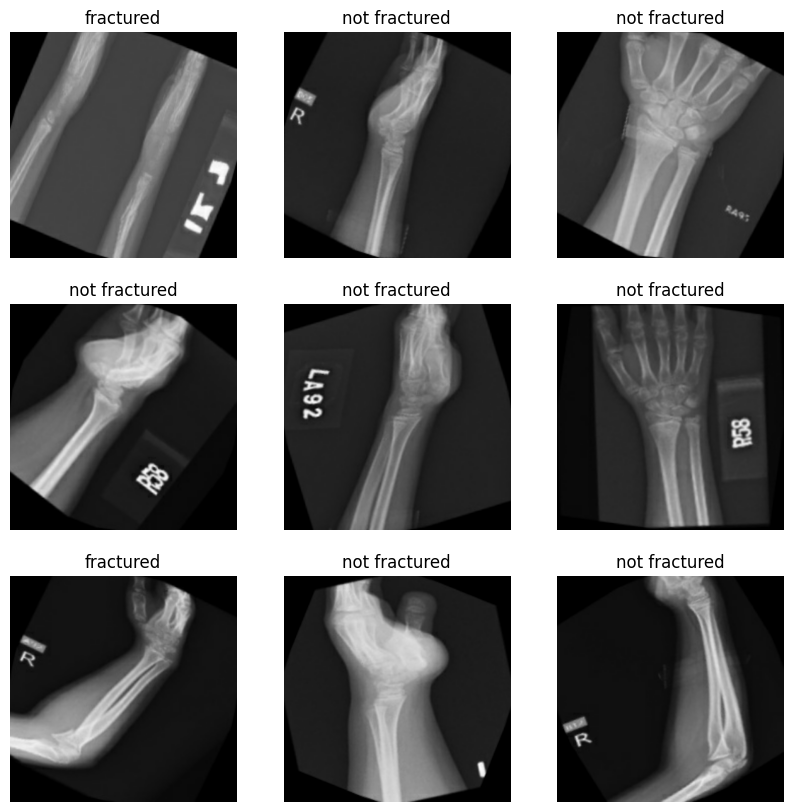

In [10]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [15]:
inception = tf.keras.applications.inception_v3.InceptionV3 (input_shape = (360,360,3),
                                                            include_top = False,
                                                            weights = 'imagenet')
inception.trainable = False
out = inception.get_layer('mixed8').output

base = tf.keras.Model(inputs=inception.input, outputs=out)

In [16]:
# Data augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

In [17]:
model = tf.keras.models.Sequential([tf.keras.Input(shape=(360,360,3)),
                                    data_augmentation,
                                    base,
                                    tf.keras.layers.GlobalAvgPool2D(),
                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.Dense(32, activation='relu'),
                                    tf.keras.layers.Dense(1, activation='sigmoid')
                                    ])

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights = True,verbose = 1),
             tf.keras.callbacks.ModelCheckpoint(filepath='model.keras', monitor='val_accuracy', save_best_only=True)]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [18]:
history = model.fit(train_dataset,epochs=100,validation_data=validation_dataset,callbacks=[callbacks])

Epoch 1/100
277/277 [==============================] - ETA: 0s - loss: 0.8830 - accuracy: 0.5615 

ValueError: ignored